In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Library Imports

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from matplotlib import pyplot
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import shutil
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# Visualizing the images using OpenCV

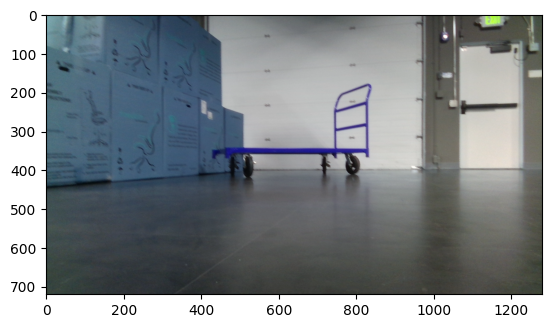

In [ ]:
img_test = cv2.imread('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_279.png')
plt.imshow(img_test)

In [ ]:
img_test.shape

(720, 1280, 3)

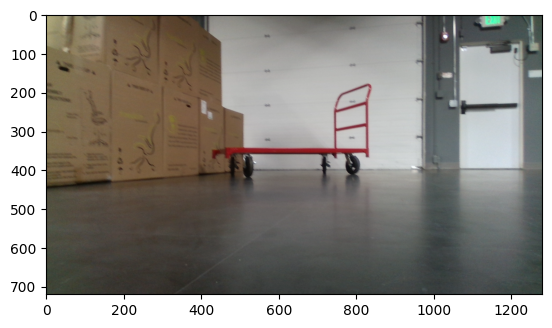

In [ ]:
img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
dir = '/content/drive/MyDrive/sample_dataset/images'
files_list = os.listdir(dir)
files_list[:10]

['training_images_take_7_405.png',
 'training_images_take_7_307.png',
 'training_images_take_7_302.png',
 'training_images_take_7_370.png',
 'training_images_take_7_315.png',
 'training_images_take_7_468.png',
 'training_images_take_7_367.png',
 'training_images_take_7_489.png',
 'training_images_take_7_445.png',
 'training_images_take_7_394.png']

In [ ]:
len(files_list)

200

# Extracting Class and Coordinates from labeled data

> Indented block



In [ ]:
def extract_info(json_path):

  with open(json_path, 'rb') as f:
    json_string = json.load(f)

  coordinates = []
  for obj in json_string:
    if "ObjectClassName" in obj and "Left" in obj and "Top" in obj and "Right" in obj and "Bottom" in obj:
      objectClassName = obj["ObjectClassName"]
      left = obj["Left"]
      top = obj["Top"]
      right = obj["Right"]
      bottom = obj["Bottom"]

      coordinates.append({"ObjectClassName": objectClassName,  "Left": left, "Top": top, "Right": right, "Bottom": bottom})

  return coordinates


In [ ]:
json_path = r'/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_279.json'
info = extract_info(json_path)
info

[{'ObjectClassName': 'Wheel',
  'Left': 505,
  'Top': 363,
  'Right': 544,
  'Bottom': 422},
 {'ObjectClassName': 'Wheel',
  'Left': 470,
  'Top': 366,
  'Right': 500,
  'Bottom': 418},
 {'ObjectClassName': 'Wheel',
  'Left': 707,
  'Top': 366,
  'Right': 735,
  'Bottom': 414},
 {'ObjectClassName': 'Wheel',
  'Left': 770,
  'Top': 361,
  'Right': 813,
  'Bottom': 415},
 {'ObjectClassName': 'Dolly',
  'Left': 420,
  'Top': 172,
  'Right': 848,
  'Bottom': 428}]

# Drawing boxes around classes

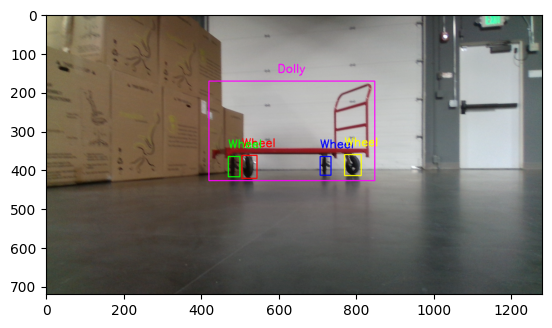

In [ ]:
def plot_bbox(img, info):
  colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_thickness = 2

  for i, box in enumerate(info):

    color = colors[i % len(colors)]
    left, top, right, bottom = box['Left'], box['Top'], box['Right'], box['Bottom']
    objectClassName = box['ObjectClassName']
    cv2.rectangle(img, (left, top), (right, bottom), color, thickness=2)
    (text_width, text_height), _ = cv2.getTextSize(objectClassName, font, font_scale, font_thickness)

    text_left = max(left, left + (right - left) // 2 - text_width // 2)  #This line calculates the horizontal position where the text should be placed.
                                                                       #It ensures that the text is centered within the bounding box of the detected object
    cv2.putText(img, objectClassName, (text_left, top - text_height), font, font_scale, color, font_thickness)

  plt.imshow(img)
  plt.show()

plot_bbox(img_rgb, info)

# Linking images to their labeled counterpart
In the previous section we extracted information from the labeled image and used it to draw on the unlabeled image. To make work possible let's create a function that intakes the image's path and outputs the labeled json of the image


In [ ]:
def get_labeled_path(img_path , format = 'json'):
  base_path = os.path.dirname(os.path.dirname(img_path)) #twice because we don't want /images
  img_filename = os.path.basename(img_path)
  img_name, _ = os.path.splitext(img_filename)
  if "augmented_images" in img_path:
        labeled_filename = f"{img_name}.{format}"
        labeled_path = os.path.join(base_path, "augmented_labels", format, labeled_filename)
  else:
      labeled_filename = f"{img_name}.{format}"
      labeled_path = os.path.join(base_path, "labels", format, labeled_filename)
  return labeled_path

In [ ]:
img_path  = '/content/drive/MyDrive/sample_dataset/images/training_images_take_7_279.png'
labeled_path = get_labeled_path(img_path)
labeled_path

'/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_279.json'

# Merging the two previous functions into one

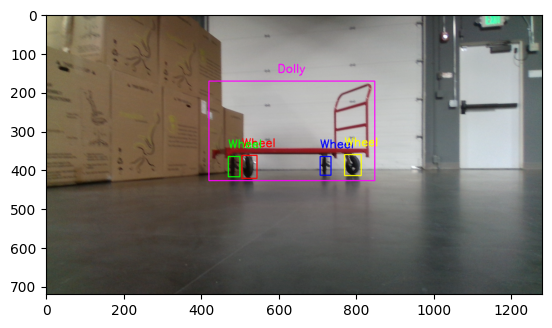

In [ ]:
def plot_objectclasses(img_path):

  labeled_path = get_labeled_path(img_path)
  info = extract_info(labeled_path)
  img = cv2.imread(img_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plot_bbox(img_rgb, info)

plot_objectclasses('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_279.png')

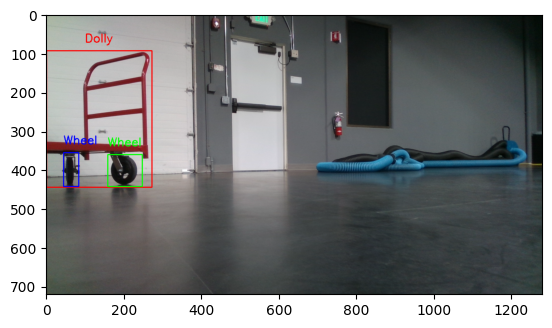

In [ ]:
plot_objectclasses('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_331.png')

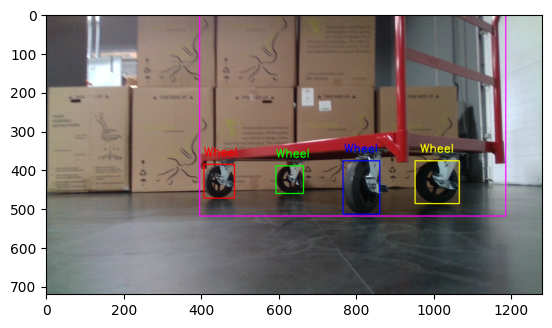

In [ ]:
plot_objectclasses('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_482.png')

# Encapsulating previous code inside of a class
In the next section you will find the `ImageLabeler` class

In [ ]:
class ImageLabeler:

  def __init__(self, img_path):
    self.img_path = img_path

  def extract_info(self, json_path):

    with open(json_path, 'rb') as f:
      json_string = json.load(f)
    coordinates = []
    for obj in json_string:
      if "ObjectClassName" in obj and "Left" in obj and "Top" in obj and "Right" in obj and "Bottom" in obj:
        objectClassName = obj["ObjectClassName"]
        left = obj["Left"]
        top = obj["Top"]
        right = obj["Right"]
        bottom = obj["Bottom"]
      coordinates.append({"ObjectClassName": objectClassName, "Left": left, "Top": top, "Right": right, "Bottom": bottom})
    return coordinates

  def get_labeled_path(self):
    base_path = os.path.dirname(os.path.dirname(self.img_path)) #twice because we don't want /images
    img_filename = os.path.basename(self.img_path)
    img_name, _ = os.path.splitext(img_filename)

    if "augmented_images" in self.img_path:
        labeled_filename = f"{img_name}.json"
        labeled_path = os.path.join(base_path, "augmented_labels", "json", labeled_filename)
    else:
        labeled_filename = f"{img_name}.json"
        labeled_path = os.path.join(base_path, "labels", "json", labeled_filename)
    return labeled_path

  def plot_objectclasses(self):

    labeled_path = self.get_labeled_path()
    info = self.extract_info(labeled_path)
    img = cv2.imread(self.img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plot_bbox(img_rgb, info)


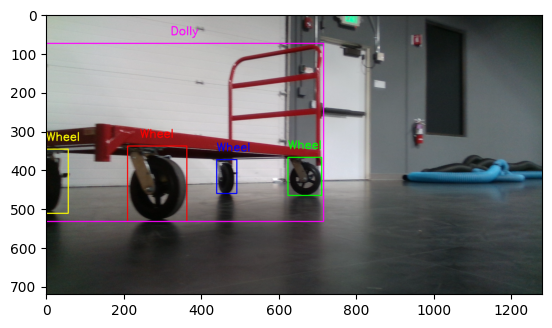

In [ ]:
lbl_test = ImageLabeler('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_417.png')
lbl_test.plot_objectclasses()

# Possibility of data augmentation

In [ ]:
# import imgaug.augmenters as iaa
# import glob

# def augment_images(images_directory):

#   path = images_directory + '/*.png'
#   imgs_path = glob.glob(path)
#   imgs = []

#   for img_path in imgs_path:
#     img = cv2.imread(img_path)
#     imgs.append(img)

#   augmentation = iaa.Sequential([
#         iaa.Fliplr(0.5),               # Horizontal flips with 50% chance
#         iaa.Affine(rotate=(-30, 30)), # Rotation between -30 and 30 degrees
#         iaa.Affine(scale=(0.8, 1.2)), # Scaling between 0.8 and 1.2
#         iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur with sigma in range 0 to 1.0
#         iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))  # Add Gaussian noise
#     ])

#   augmented_imgs = augmentation(images = imgs)
#   for i in range(9):
#       pyplot.subplot(330 + 1 + i)
#       plt.imshow(augmented_imgs[i])
#   plt.show()







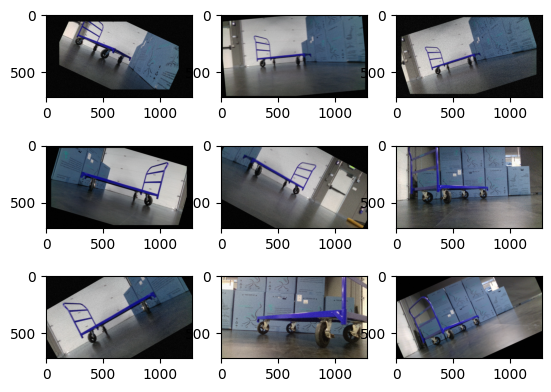

In [ ]:
# augment_images('/content/drive/MyDrive/sample_dataset/images')

In [ ]:
!chmod 777 /content/drive/MyDrive/sample_dataset

In [ ]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augment_and_save(images_directory, augmented_images_directory, augmented_labels_directory, nb_of_augs=1):

    for filename in os.listdir(images_directory):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):

            image_path = os.path.join(images_directory, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


            labeled_path = get_labeled_path(image_path)
            with open(labeled_path, "rb") as f:
                data = json.load(f)

            bboxes = []
            for item in data:
                if item["ObjectClassName"] == "Wheel" or item["ObjectClassName"] == "Dolly":
                    bboxes.append(BoundingBox(x1=item["Left"], y1=item["Top"], x2=item["Right"], y2=item["Bottom"]))

            bboi = BoundingBoxesOnImage(bboxes, shape=image.shape)

            # Define the augmentation pipeline
            augmentation = iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
                iaa.Affine(rotate=(-20, 20)),
                iaa.AverageBlur(k=(2, 7))
            ])

            for i in range(nb_of_augs):
                # Perform data augmentation
                image_aug, bbs_aug = augmentation(image=image, bounding_boxes=bboi)

                # Save the augmented image
                name_to_add = '_aug_'+ str(i)
                destination_filename = os.path.splitext(filename)[0] + name_to_add + '.png'
                cv2.imwrite(os.path.join(augmented_images_directory, destination_filename), cv2.cvtColor(image_aug, cv2.COLOR_RGB2BGR))

                # Update the JSON data with the new bounding box coordinates
                for item, bb in zip(data, bbs_aug.bounding_boxes):
                    item["Left"], item["Top"], item["Right"], item["Bottom"] = int(bb.x1), int(bb.y1), int(bb.x2), int(bb.y2)

                # Save the updated JSON data
                destination_filename = os.path.splitext(filename)[0] + name_to_add + '.json'
                json_to_write = os.path.join(augmented_labels_directory, destination_filename)
                with open(json_to_write, "w") as f:
                    json.dump(data, f, indent=4)




In [ ]:
images_directory = '/content/drive/MyDrive/sample_dataset/images'
augmented_images_directory = '/content/drive/MyDrive/sample_dataset/augmented_images'
augmented_labels_directory = '/content/drive/MyDrive/sample_dataset/augmented_labels/json'

if not os.path.exists(augmented_images_directory):
    os.makedirs(augmented_images_directory)
if not os.path.exists(augmented_labels_directory):
    os.makedirs(augmented_labels_directory)

augment_and_save(images_directory, augmented_images_directory, augmented_labels_directory)

In [ ]:
# !find /content/drive/MyDrive/sample_dataset/augmented_labels -type f -delete


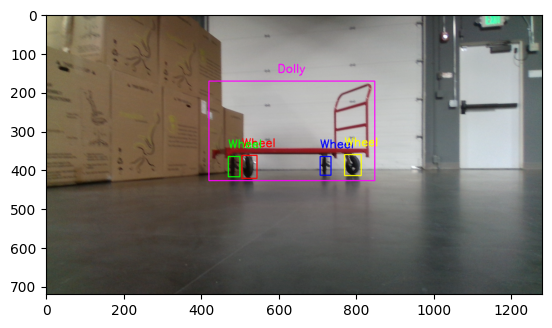

In [ ]:
lbl_test1 = ImageLabeler('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_279.png')
lbl_test1.plot_objectclasses()

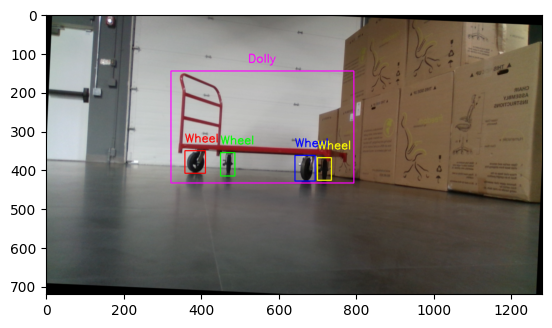

In [ ]:
lbl_test1_aug = ImageLabeler('/content/drive/MyDrive/sample_dataset/augmented_images/training_images_take_7_289_aug_0.png')
lbl_test1_aug.plot_objectclasses()

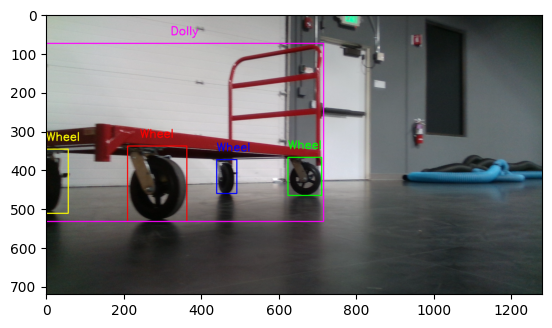

In [ ]:
lbl_test2 = ImageLabeler('/content/drive/MyDrive/sample_dataset/images/training_images_take_7_417.png')
lbl_test2.plot_objectclasses()

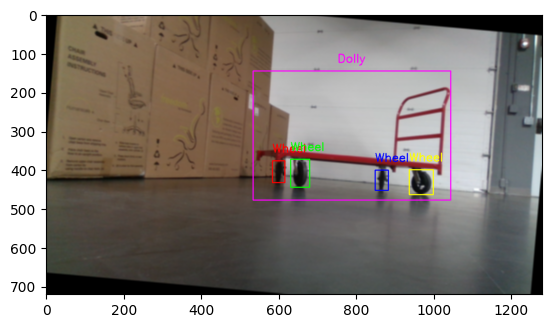

In [ ]:
lbl_test2_aug = ImageLabeler('/content/drive/MyDrive/sample_dataset/augmented_images/training_images_take_7_300_aug_0.png')
lbl_test2_aug.plot_objectclasses()

# Train Test Split

In [ ]:
def train_test_split_prep(images_directories, format = 'json'):
    image_paths = []
    labeled_paths = []
    for images_directory in images_directories:
      for filename in os.listdir(images_directory):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
          image_path = os.path.join(images_directory, filename)
          image_paths.append(image_path)
          labeled_paths.append(get_labeled_path(image_path, format))

    return image_paths, labeled_paths


In [ ]:
img_arr, labeled_arr = train_test_split_prep(['/content/drive/MyDrive/sample_dataset/images', '/content/drive/MyDrive/sample_dataset/augmented_images'])

In [ ]:
print(img_arr[134])
print(labeled_arr[134])

print("-------------")

print(img_arr[234])
print(labeled_arr[234])

/content/drive/MyDrive/sample_dataset/images/training_images_take_7_475.png
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_475.json
-------------
/content/drive/MyDrive/sample_dataset/augmented_images/training_images_take_7_317_aug_0.png
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_317_aug_0.json


In [ ]:
train_image, test_image, train_label, test_label = train_test_split(img_arr, labeled_arr, test_size=0.2, random_state=42)

In [ ]:
print(f'Training images: {len(train_image)}')
print(f'Training Labels: {len(train_label)}')
print(f'Test images: {len(test_image)}')
print(f'Test Labels: {len(test_label)}')

Training images: 320
Training Labels: 320
Test images: 80
Test Labels: 80


In [ ]:
train_df = pd.DataFrame(train_image, train_label)
train_df

,0
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_370.json,/content/drive/MyDrive/sample_dataset/images/t...
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_443.json,/content/drive/MyDrive/sample_dataset/images/t...
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_302_aug_0.json,/content/drive/MyDrive/sample_dataset/augmente...
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_319_aug_0.json,/content/drive/MyDrive/sample_dataset/augmente...
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_294_aug_0.json,/content/drive/MyDrive/sample_dataset/augmente...
...,...
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_339.json,/content/drive/MyDrive/sample_dataset/images/t...
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_454.json,/content/drive/MyDrive/sample_dataset/images/t...
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_481_aug_0.json,/content/drive/MyDrive/sample_dataset/augmente...
/content/drive/MyDrive/sample_dataset/augmented_labels/json/training_images_take_7_458_aug_0.json,/content/drive/MyDrive/sample_dataset/augmente...


# Formatting JSON files to make them compatible with YOLOv5

In [ ]:
# def format_labels(json_path, new_folder_path):

#   image_width = 1280
#   image_height = 720

#   output_lines = []

#   info = extract_info(json_path)
#   for obj in info:
#     class_name = obj["ObjectClassName"]
#     left = obj["Left"]
#     top = obj["Top"]
#     right = obj["Right"]
#     bottom = obj["Bottom"]

#     x_center = (left + right) / (2 * image_width)
#     y_center = (top + bottom) / (2 * image_height)
#     width = (right - left) / image_width
#     height = (bottom - top) / image_height

#     output_line = f"{class_name} {x_center} {y_center} {width} {height}"
#     output_lines.append(output_line)

#   json_basename = f"{os.path.splitext(os.path.basename(json_path))[0]}.txt"



#   output_filename =  os.path.join(new_folder_path, json_basename)
#   with open(output_filename, "w") as output_file:
#     output_file.write("\n".join(output_lines))


def format_labels(json_path, txt_output_path):

    image_width = 1280
    image_height = 720

    with open(json_path, 'r') as f:
        annotations = json.load(f)

    output_lines = []

    for annotation in annotations:
        class_name = annotation["ObjectClassName"]
        left = annotation["Left"]
        top = annotation["Top"]
        right = annotation["Right"]
        bottom = annotation["Bottom"]

        x_center = (left + right) / (2 * image_width)
        y_center = (top + bottom) / (2 * image_height)
        width = (right - left) / image_width
        height = (bottom - top) / image_height

        output_line = f"{class_name} {x_center} {y_center} {width} {height}"
        output_lines.append(output_line)

    output_filename = os.path.splitext(os.path.basename(json_path))[0] + ".txt"
    output_file_path = os.path.join(txt_output_path, output_filename)

    with open(output_file_path, "w") as output_file:
        output_file.write("\n".join(output_lines))




In [ ]:
new_folder_path = r'/content/drive/MyDrive/sample_dataset/labels/txt'

if not os.path.exists(new_folder_path):
  os.makedirs(new_folder_path)

format_labels('/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_279.json', new_folder_path)

In [ ]:
def format_all_labels(input_dir, output_dir):
    json_files = [filename for filename in os.listdir(input_dir) if filename.lower().endswith(".json")]

    for json_file in json_files:
        json_path = os.path.join(input_dir, json_file)
        format_labels(json_path, output_dir)

# Define directories
input_labels_dir1 = '/content/drive/MyDrive/sample_dataset/labels/json'
output_labels_dir1 = '/content/drive/MyDrive/sample_dataset/labels/txt'

input_labels_dir2 = '/content/drive/MyDrive/sample_dataset/augmented_labels/json'
output_labels_dir2 = '/content/drive/MyDrive/sample_dataset/augmented_labels/txt'



# # Format labels from the first input directory
format_all_labels(input_labels_dir1, output_labels_dir1)

# # Format labels from the second input directory
format_all_labels(input_labels_dir2, output_labels_dir2)


In [ ]:
os. getcwd()

'/content'